In [1]:
import numpy as np
from lattice import Lattice2D, BrickwallLattice, SquareLattice
import matplotlib.pyplot as plt

In [14]:
omega = 2 * np.pi / 3
T = 2 * np.pi / omega

l = Lattice2D(
    dimensions=(6, 12),
    t_hop=1,
    E_amplitude=lambda t: np.cos(omega * t),
    E_dir=np.array([1, 0]),
    h=5e-3,
    T=50 * T,
    initial_occupation=0.5,
)

Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.
50 % of states were set as initially occupied.


In [15]:
l.evolve(options={"progress_bar": True})

10.0%. Run time:  81.37s. Est. time left: 00:00:12:12
20.0%. Run time: 160.70s. Est. time left: 00:00:10:42
30.0%. Run time: 240.77s. Est. time left: 00:00:09:21
40.0%. Run time: 320.05s. Est. time left: 00:00:08:00
50.0%. Run time: 414.96s. Est. time left: 00:00:06:54
60.0%. Run time: 499.38s. Est. time left: 00:00:05:32
70.0%. Run time: 584.51s. Est. time left: 00:00:04:10
80.0%. Run time: 669.89s. Est. time left: 00:00:02:47
90.0%. Run time: 755.04s. Est. time left: 00:00:01:23
100.0%. Run time: 839.30s. Est. time left: 00:00:00:00
Total run time: 839.30s


In [30]:
def get_fft_range(t_signal, max_freq, h):
    """Computes DFT of t_signal and returns amplitudes for frequencies below max_freq."""
    freqs = np.fft.fftfreq(len(t_signal), d=h)
    mask = (freqs < max_freq) & (freqs > 0)
    return freqs[mask], np.abs(np.fft.fft(t_signal))[mask]

In [36]:
l.save_current_density_animation("sim_pol_results/rect6x12w2pi3h5e-3T50.mp4", sample_every=111, fps=30)

Generating animation: 100%|█████████▉| 269/270 [01:56<00:00,  2.30frame/s]


In [81]:
t = np.arange(0, l.steps * l.h, l.h)

E = np.cos(omega * t)
P = [state.polarisation[1] for state in l.states]
P_current = np.diff(P) / l.h
M = [state.curl_polarisation[0] for state in l.states]
M_current = np.diff(M) / l.h

P /= np.max(np.abs(P))
P_current /= np.max(np.abs(P_current))
M /= np.max(np.abs(M))
M_current /= np.max(np.abs(M_current))

cutoff_freq = 2 * omega
freqs, P_fft = get_fft_range(P, cutoff_freq, l.h)
_, E_fft = get_fft_range(E, cutoff_freq, l.h)
_, M_fft = get_fft_range(M, cutoff_freq, l.h)

freqs /= omega / (2 * np.pi)

<Figure size 640x480 with 0 Axes>

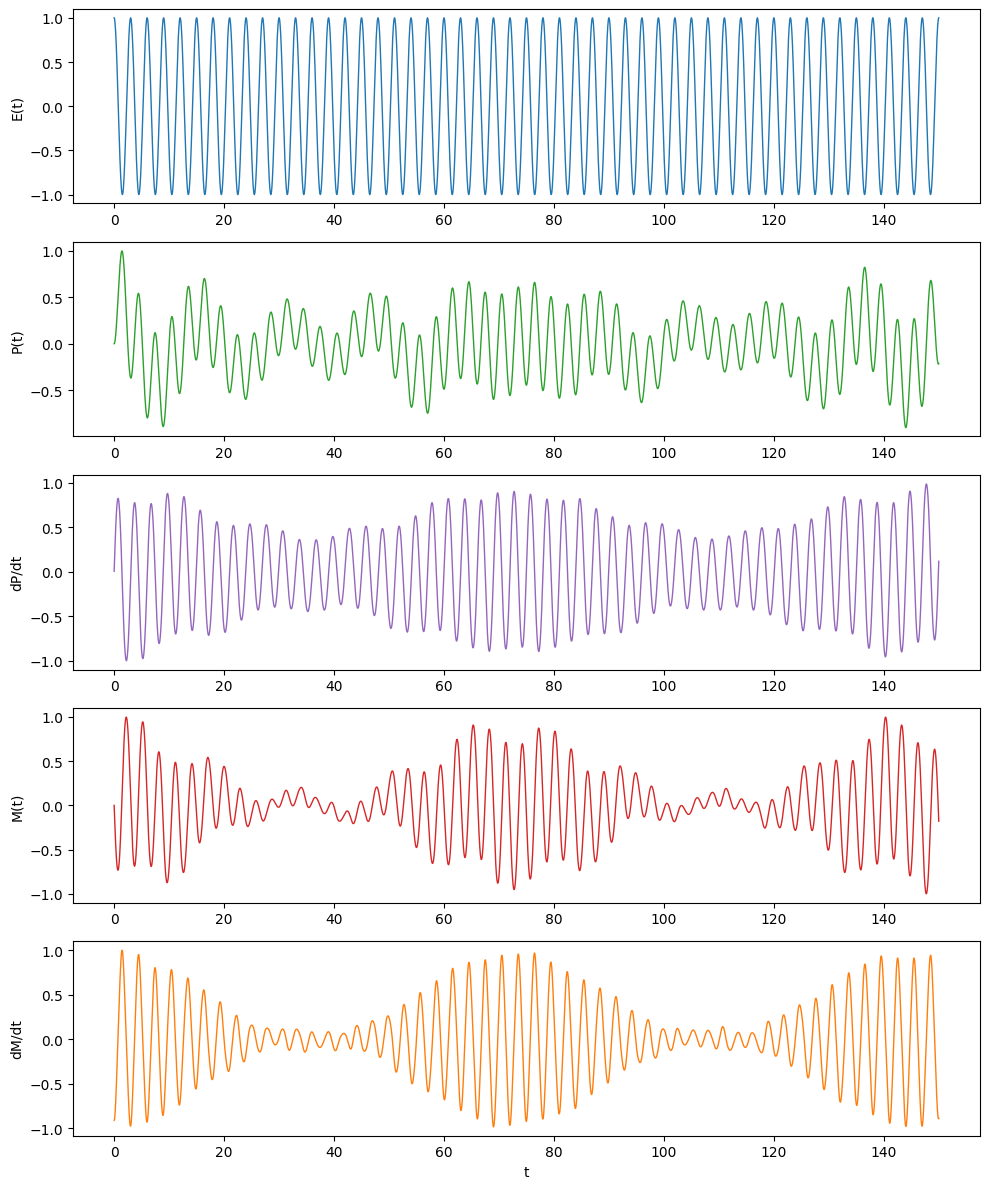

In [94]:
plt.cla()
plt.clf()
plt.rcParams['lines.linewidth'] = 1

fig, axs = plt.subplots(5, 1, figsize=(10, 12))


axs[0].plot(t, E, label="E(t)", color="tab:blue")
axs[0].set_ylabel("E(t)")

axs[1].plot(t, P, label="P(t)", color="tab:green")
axs[1].set_ylabel("P(t)")

axs[2].plot(t[:-1], P_current, label="dP/dt", color="tab:purple")
axs[2].set_ylabel("dP/dt")

axs[3].plot(t, M, label="M(t)", color="tab:red")
axs[3].set_ylabel("M(t)")

axs[4].plot(t[:-1], M_current, label="dM/dt", color="tab:orange")
axs[4].set_ylabel("dM/dt")

axs[4].set_xlabel("t")

plt.tight_layout()
plt.savefig("sim_pol_results/rect6x12w2pi3h5e-3T50.pdf")
plt.show()

In [97]:
def E_field(t):
    return np.cos(omega * t)

l.E = E_field

l.save("sim_pol_results/rect6x12w2pi3h5e-3T50.lattice")

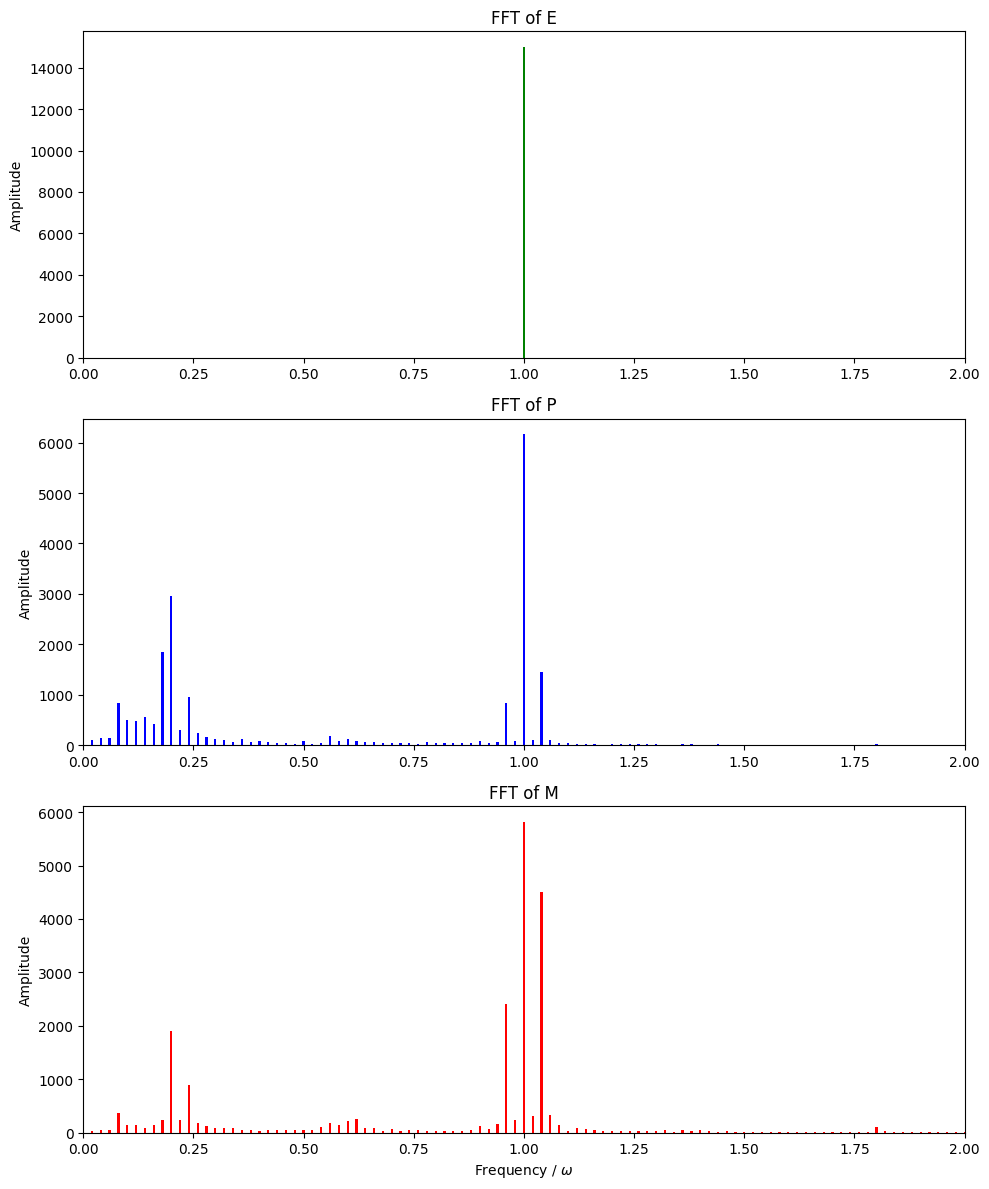

In [85]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].bar(freqs, E_fft, color='green', width=l.h)
axs[0].set_title('FFT of E')
axs[0].set_ylabel('Amplitude')

axs[1].bar(freqs, P_fft, color='blue', width=l.h)
axs[1].set_title('FFT of P')
axs[1].set_ylabel('Amplitude')

axs[2].bar(freqs, M_fft, color='red', width=l.h)
axs[2].set_title('FFT of M')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Frequency / $\\omega$')

for ax in axs:
    ax.set_xlim(0, cutoff_freq / omega)

plt.tight_layout()
plt.savefig("sim_pol_results/rect6x12w2pi3h5e-3T50_fft.pdf")
plt.show()

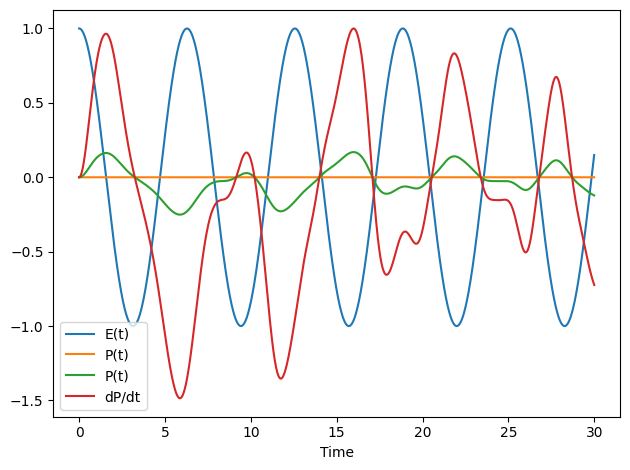

In [64]:
plt.clf()

t = np.linspace(0, l.steps*l.h, l.steps)
P = [b.states[i].polarisation for i in range(l.steps)]
C_J = [b.states[i].curl_polarisation for i in range(l.steps)]
P_C = np.diff(P) / l.h

P_C /= np.max(P_C)

plt.plot(t[:-1], E(t)[:-1], label="E(t)")
plt.plot(t[:-1], P[:-1], label="P(t)")
# plt.plot(t, C_J, label="C_J(t)")
plt.plot(t, P_C, label="dP/dt")

plt.xlabel("Time")
plt.tight_layout()
plt.legend()
plt.show()


# # Compute FFT on the signals
# dt = l.h
# N = len(t)
# freq = np.fft.fftfreq(N, d=dt)

# # Evaluate E(t) and convert P and C_J to arrays (each sample is a 2-component vector)
# E_vals = E(t)
# P_arr = np.array(P)       # shape: (N, 2)
# C_J_arr = np.array(C_J)   # shape: (N, 2)

# # Compute FFTs: for vector signals we compute FFT on each component
# E_fft = np.fft.fft(E_vals)
# P_fft = np.fft.fft(P_arr, axis=0)
# C_J_fft = np.fft.fft(C_J_arr, axis=0)

# # Create a new figure with two subplots:
# plt.figure(figsize=(10, 8))

# r = 400
# R = np.argmax(np.abs(E_fft)) + 390
# print(R)

# plt.plot(freq[R-r:R+r], np.abs(E_fft)[R-r:R+r], label="|FFT E(t)|")
# plt.plot(freq[R-r:R+r], np.abs(C_J_fft[:, 0])[R-r:R+r], label="|FFT C_J_x(t)|")
# plt.title("DFT Spectrum for Lattice Signals (l)")
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.legend()
# plt.plot(freq[R-r:R+r], np.abs(P_fft[:, 1])[R-r:R+r], label="|FFT P_y(t)|")
# plt.title("DFT Spectrum for Polarisation (p)")
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.legend()
# plt.show()


In [ ]:
l = BrickwallLattice(
    dimensions=(7, 12),
    t_hop=1,
    E_amplitude=cos_func,
    E_dir=np.array([1, 0]),
    h=2e-3,
    T=12,
    initial_occupation=0.5,
)

l.evolve(options={"progress_bar": True})
l.save_current_density_animation("polarized-bw-lattice.gif", sample_every=97, curl_norm=l.maximum_curl, fps=15)

Creating Hamiltonians...
Done.
Calculating energy eigenstates...
Done.
50 % of states were set as initially occupied.
10.0%. Run time:  15.29s. Est. time left: 00:00:02:17
20.0%. Run time:  23.38s. Est. time left: 00:00:01:33
30.0%. Run time:  35.52s. Est. time left: 00:00:01:22
40.0%. Run time:  44.99s. Est. time left: 00:00:01:07
50.0%. Run time:  55.74s. Est. time left: 00:00:00:55
60.0%. Run time:  70.70s. Est. time left: 00:00:00:47
70.0%. Run time:  80.51s. Est. time left: 00:00:00:34
80.0%. Run time:  95.28s. Est. time left: 00:00:00:23
90.0%. Run time: 108.94s. Est. time left: 00:00:00:12
100.0%. Run time: 119.54s. Est. time left: 00:00:00:00
Total run time: 119.54s


Generating animation:  98%|█████████▊| 60/61 [00:23<00:00,  2.56frame/s]


In [ ]:
class BrickwallLattice(Lattice2D):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.cell_path = np.array([(0, 1), (1, 2), (2, self.Lx+2), (self.Lx+2, self.Lx+1), (self.Lx+1, self.Lx), (self.Lx, 0)])


    def get_brickwall_lattice_sites(self) -> np.ndarray:
        if self.Lx % 2 == 0:
            y_hop_row = np.tile([0, 1], self.Lx//2)
            y_hop = np.concatenate([y_hop_row, 1 - y_hop_row] * (self.Ly // 2 - 1) + [y_hop_row])
        else:
            y_hop = np.tile([0, 1], (self.Ly-1)*self.Lx//2)
            y_hop = np.concatenate([y_hop, [0] * (1- self.Ly % 2)])
        
        erase_positions = np.diag(y_hop, self.Lx) + np.diag(y_hop, -self.Lx)
        return 1-erase_positions
    
    
    def create_hopping_hamiltonian(self):
        return super().create_hopping_hamiltonian() * self.get_brickwall_lattice_sites()
    
    def curl(self, J: np.ndarray) -> np.ndarray:
        cell_width = (self.cell_path.flatten() % self.Lx).max()
        cell_height = (self.cell_path.flatten() // self.Lx).max()
        curl = dict()
        # curl_row_length = self.L-cell_width

        for i in range(0, self.Ly - cell_height, cell_height):
            for j in range(i%2, self.Lx - cell_width, cell_width):
                site_index = self.Lx * i + j
                curl[site_index] = sum([J[site_index + di, site_index + dj] for di, dj in self.cell_path])
        return curl
    
    
        
    

class SquareLattice(Lattice2D):
    def __init__(self, L: int, *args, **kwargs):
        super().__init__(dimensions=(L, L), *args, **kwargs)
        self.L = L



# Todo

Smaller frequencies of E but with $$T/2 < T_{reflection}$$